In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

# Download data and export to `data` folder

Data is available [here](https://drive.google.com/open?id=1hVwbKjNfiHzs7FzcDjsRwcqxvybke_Ji) or within the [GitHub Repo](https://github.com/zerafachris/g2net_malta_hackaton/tree/master/data).

Kindly download and place into a folder `/data/` so the following notebooks work.



# Introduction

The following notebook contains an introduction to the data you are going to use for the Hackaton.

The data used for the challenge contains earthquake from all over the world, together with noise (non-earthquake ambient noise).

You are provided with 3 pickle files:
- `df_train.pkl.gzip` and `df_test.pkl.gzip`: Labelled datasets with earthquake meta data and 3 traces (E-N-Z).
- `df_submission.pkl.gzip`. Unlabelled data to be submitted at the end of the challange.


# Load the data

In [2]:
# When loading be sure to define the compression
df_train = pd.read_pickle('./data/df_train.pkl.gzip', compression='gzip')

In [3]:
print('Shape {}'.format(df_train.shape))
df_train.head()

Shape (12308, 19)


label  target trace_id  receiver_latitude  receiver_longitude  \
1   Near_Small       1  trace_1          33.598182         -116.596005   
2   Far_Medium       5  trace_2          33.655160         -115.990060   
4  Near_Medium       2  trace_4          19.333395         -155.385650   
5    Far_Small       4  trace_5          35.935700         -117.601700   
6        Noise       0  trace_6          64.564600         -165.373200   

   receiver_elevation_m  p_arrival_sample  p_travel_sec  s_arrival_sample  \
1                1374.8             500.0       7.39588            1833.0   
2                 538.0             800.0       8.64000            2055.2   
4                 836.0             900.0       7.77000            1401.0   
5                1042.6             800.0       2.68000            1416.0   
6                 338.0             697.2       1.41000             674.0   

       source_origin_time  source_latitude  source_longitude  source_depth_km  \
1 2017-10-12 02:55:02.969        35.561667         -116.5697            13.92   
2 2012-05-29 21:39:41.030        69.509000         -116.3350             5.56   
4 2018-04-23 03:03:17.385        33.075200           73.6821             9.41   
5 2013-03-11 16:56:06.060        38.612300         -122.6970           118.79   
6 2018-01-05 13:16:17.060        60.036800         -155.2055             2.17   

    snr_db_E   snr_db_N   snr_db_Z  \
1  39.799999  41.599998  39.500000   
2  22.900000  28.299999  22.299999   
4  12.600000  22.000000  18.299999   
5  30.600000  29.100000  33.000000   
6  47.099998  18.100000  49.400002   

                                                   E  \
1  [0.0, 3.884492e-05, 0.00037855064, 0.002025907...   
2  [-0.0, 0.007055464, 0.02053014, -0.08816139, -...   
4  [0.0, 0.00087343936, 0.001654511, 0.003251037,...   
5  [-0.0, -0.00044424256, -0.00061723316, -0.0027...   
6  [-0.0, -0.0059266915, -0.01604839, -0.04224359...   

                                                   N  \
1  [-0.0, -0.00013965365, 0.00040082424, -0.00251...   
2  [0.0, 0.0045861118, -0.013594023, -0.06492513,...   
4  [-0.0, -0.0024113357, -0.0057321144, -0.017913...   
5  [0.0, 2.6028414e-05, -0.00040918458, 0.0047532...   
6  [-0.0, -0.0059266915, -0.01604839, -0.04224359...   

                                                   Z  
1  [0.0, 0.00020642515, -0.00026392427, 0.0005670...  
2  [0.0, 0.010553602, 0.04499443, 0.07075505, -0....  
4  [-0.0, -0.00079455395, -0.0040257163, -0.01145...  
5  [0.0, 0.00034063237, 0.0003412804, 0.000484175...  
6  [-0.0, -0.0059266915, -0.01604839, -0.04224359...

As you can see above, each event has 19 parameters:

1. **label** - Text label describing the event
1. **target** - Categorical label describing the event
1. **trace_id** - id to identify the event in our database
1. **receiver_latitude** - latitude location of the receiver
1. **receiver_longitude** - longitudinal location of the receiver
1. **receiver_elevation_m** - Elevalation in metres from see level for the receiver
1. **p_arrival_sample** - predicted p-wave arrival. In the case of noise, there is still an arrival, however this is incorrect
1. **p_travel_sec** - the time taken by the p-wave to travel from the source origin to the receiver location. In the case of noise this is incorrect
1. **s_arrival_sample** - predicted p-wave arrival. In the case of noise, there is still an arrival, however this is incorrect
1. **source_origin_time** - datetime for the event source
1. **source_latitude** - event source latitude
1. **source_longitude** - event source longitude
1. **source_depth_km** - event source depth in kilometers
1. **snr_db_E** - signal to noise ratio for the E-component of the seismogram trace
1. **snr_db_N** - signal to noise ratio for the N-component of the seismogram trace
1. **snr_db_Z** - signal to noise ratio for the Z-component of the seismogram trace
1. **E** - E-component of the seismogram trace
1. **N** - N-component of the seismogram trace
1. **Z** - Z-component of the seismogram trace

## Number of Targets

In [4]:
df_train[['target','label']].drop_duplicates().sort_values(by='target')

target        label
6        0        Noise
1        1   Near_Small
4        2  Near_Medium
18       3   Near_Large
5        4    Far_Small
2        5   Far_Medium
7        6    Far_Large

## Number of events per label

In [5]:
df_train.groupby("label")["trace_id"].nunique()

label
Far_Large      1760
Far_Medium     1760
Far_Small      1759
Near_Large     1756
Near_Medium    1759
Near_Small     1757
Noise          1757
Name: trace_id, dtype: int64

In total we have 7 classes or rather 6 earthquake types and the noise.

# Visualization
## Trace Visual

In [6]:
def make_eq_visual(trace):
    dt = df_train.loc[df_train['trace_id']==trace]
    row_item = dt.loc[dt['trace_id'] == trace,['target','label','trace_id']].to_string().split('\n')[1].split()
    fig, ax = plt.subplots(3, 1, figsize = (20,4), sharex=True)
    for enum_tt, tt in enumerate(['E','N','Z']):
        signal = dt[tt][int(trace.replace('trace_',''))]
        signal_min = np.min(signal)
        signal_max = np.max(signal)
        ax[enum_tt].plot(signal,'k')
        ax[enum_tt].set_ylabel('Amplitude {}'.format(tt))
        ax[enum_tt].vlines(list(dt['p_arrival_sample'])[0], signal_min, signal_max, color='b', linewidth=2, label='P-arrival')
        ax[enum_tt].vlines(list(dt['s_arrival_sample'])[0], signal_min, signal_max, color='r', linewidth=2, label='S-arrival')
        ax[enum_tt].legend(loc='upper right')        
    plt.suptitle('Target-Label-Trace_id : {}-{}-{}'.format(row_item[1],row_item[2],row_item[3]))    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    for col, val in zip(list(dt.columns),dt.values[0]):
        if col not in ['E','N','Z']:
            print('{} : {}'.format(col, val))

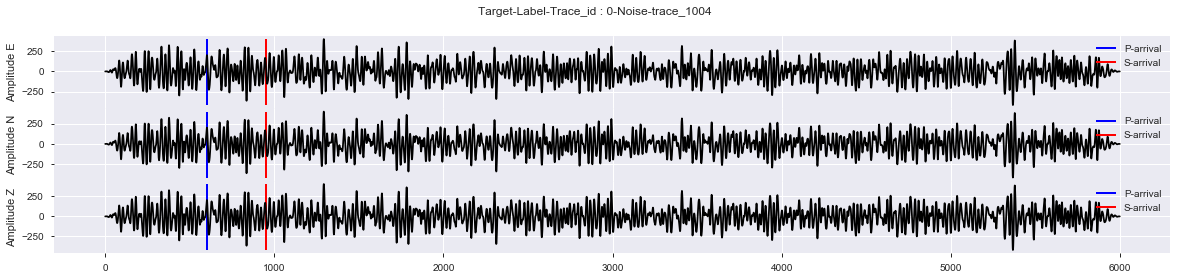

label : Noise
target : 0
trace_id : trace_1004
receiver_latitude : 49.2556
receiver_longitude : 59.9431
receiver_elevation_m : 243.0
p_arrival_sample : 600.0
p_travel_sec : 10.885000228881836
s_arrival_sample : 951.0
source_origin_time : 2007-05-25 20:50:57.900000
source_latitude : 37.6037
source_longitude : -155.3727
source_depth_km : 68.4
snr_db_E : 53.90000153
snr_db_N : 38.90000153
snr_db_Z : 29.89999962


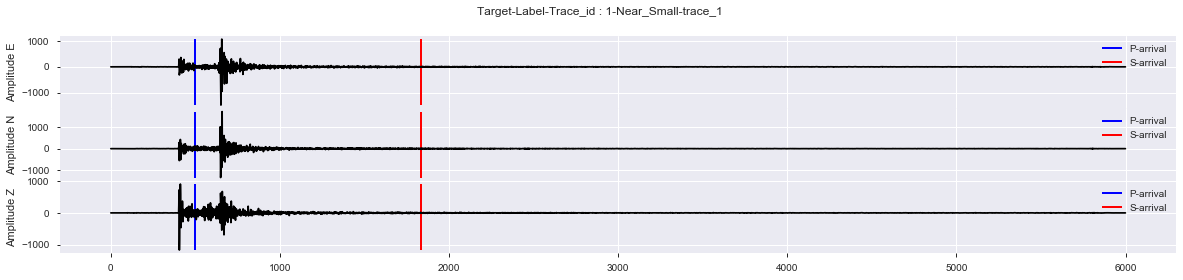

label : Near_Small
target : 1
trace_id : trace_1
receiver_latitude : 33.598182
receiver_longitude : -116.596005
receiver_elevation_m : 1374.8
p_arrival_sample : 500.0
p_travel_sec : 7.3958802223205575
s_arrival_sample : 1833.0
source_origin_time : 2017-10-12 02:55:02.969000
source_latitude : 35.5616667
source_longitude : -116.5697
source_depth_km : 13.92
snr_db_E : 39.79999924
snr_db_N : 41.59999847
snr_db_Z : 39.5


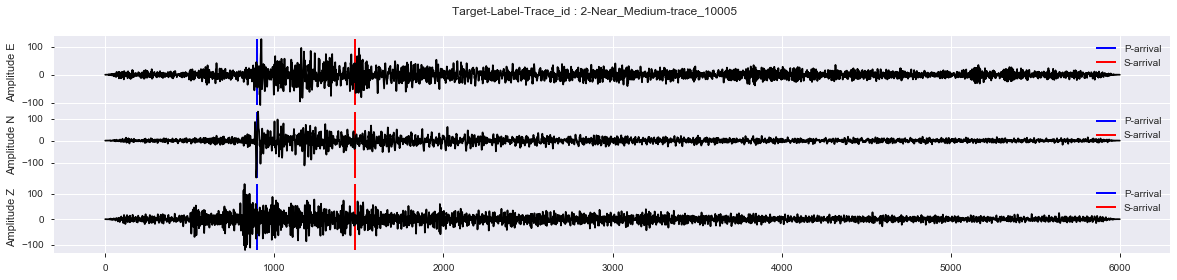

label : Near_Medium
target : 2
trace_id : trace_10005
receiver_latitude : 36.171
receiver_longitude : -89.50200000000001
receiver_elevation_m : 80.0
p_arrival_sample : 900.0
p_travel_sec : 8.050000190734862
s_arrival_sample : 1475.2
source_origin_time : 2013-06-16 01:13:08.452000
source_latitude : 53.1447
source_longitude : -147.561
source_depth_km : 113.05
snr_db_E : 13.5
snr_db_N : 20.70000076
snr_db_Z : 14.0


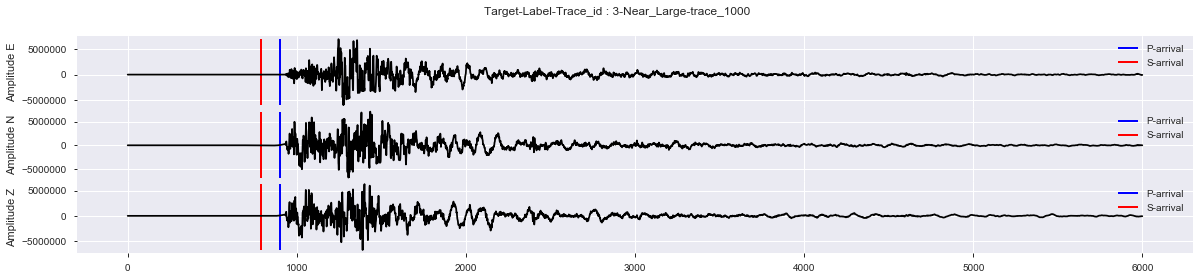

label : Near_Large
target : 3
trace_id : trace_1000
receiver_latitude : 33.6117
receiver_longitude : -116.4594
receiver_elevation_m : 1259.0
p_arrival_sample : 898.2
p_travel_sec : 28.26000022888184
s_arrival_sample : 789.0
source_origin_time : 2018-07-15 22:31:14.598000
source_latitude : 66.9586
source_longitude : -155.4909
source_depth_km : 13.69
snr_db_E : 101.69999695
snr_db_N : 100.09999847
snr_db_Z : 100.80000305


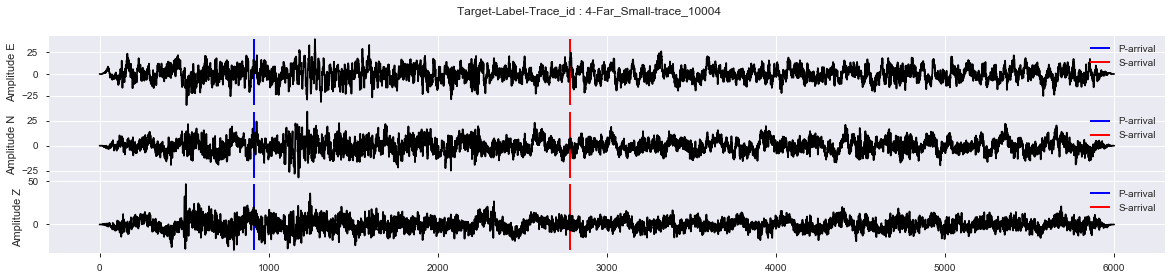

label : Far_Small
target : 4
trace_id : trace_10004
receiver_latitude : 38.985199
receiver_longitude : -119.240601
receiver_elevation_m : 1857.0
p_arrival_sample : 910.7
p_travel_sec : 4.010000228881837
s_arrival_sample : 2780.0
source_origin_time : 2012-03-14 21:15:01.114000
source_latitude : 33.91117
source_longitude : 22.1543
source_depth_km : 10.07
snr_db_E : 5.19999981
snr_db_N : 10.5
snr_db_Z : 5.4000001


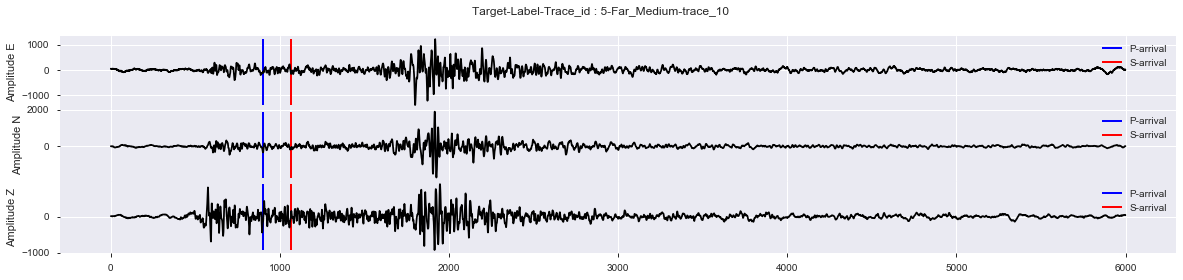

label : Far_Medium
target : 5
trace_id : trace_10
receiver_latitude : 39.2114
receiver_longitude : 25.8553
receiver_elevation_m : 90.0
p_arrival_sample : 900.0
p_travel_sec : 4.010000228881837
s_arrival_sample : 1067.0
source_origin_time : 2007-07-02 23:57:39.110000
source_latitude : 38.5256
source_longitude : -150.9599
source_depth_km : 1.06
snr_db_E : 15.0
snr_db_N : 12.5
snr_db_Z : 11.89999962


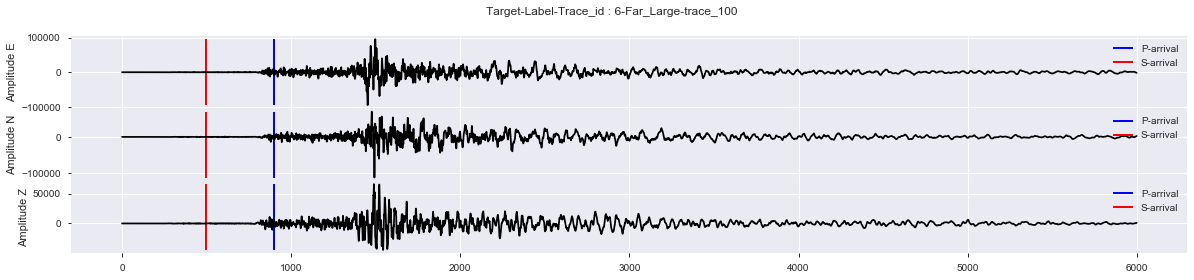

label : Far_Large
target : 6
trace_id : trace_100
receiver_latitude : 37.8902
receiver_longitude : 22.8692
receiver_elevation_m : 437.0
p_arrival_sample : 900.0
p_travel_sec : 21.473970413208008
s_arrival_sample : 496.0
source_origin_time : 2012-11-17 00:35:00.700000
source_latitude : 46.87
source_longitude : -121.09100000000001
source_depth_km : 7.02
snr_db_E : 44.5
snr_db_N : 41.90000153
snr_db_Z : 45.59999847


In [7]:
for trace in df_train.groupby('target')['trace_id'].min():
    make_eq_visual(trace)

## Overall

In [8]:
# Data Types
list(set(df_train.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('<M8[ns]'), dtype('O')]

### Numeric

In [9]:
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num.head()

target  receiver_latitude  receiver_longitude  receiver_elevation_m  \
1       1          33.598182         -116.596005                1374.8   
2       5          33.655160         -115.990060                 538.0   
4       2          19.333395         -155.385650                 836.0   
5       4          35.935700         -117.601700                1042.6   
6       0          64.564600         -165.373200                 338.0   

   p_arrival_sample  p_travel_sec  s_arrival_sample  source_latitude  \
1             500.0       7.39588            1833.0        35.561667   
2             800.0       8.64000            2055.2        69.509000   
4             900.0       7.77000            1401.0        33.075200   
5             800.0       2.68000            1416.0        38.612300   
6             697.2       1.41000             674.0        60.036800   

   source_longitude  source_depth_km   snr_db_E   snr_db_N   snr_db_Z  
1         -116.5697            13.92  39.799999  41.599998  39.500000  
2         -116.3350             5.56  22.900000  28.299999  22.299999  
4           73.6821             9.41  12.600000  22.000000  18.299999  
5         -122.6970           118.79  30.600000  29.100000  33.000000  
6         -155.2055             2.17  47.099998  18.100000  49.400002

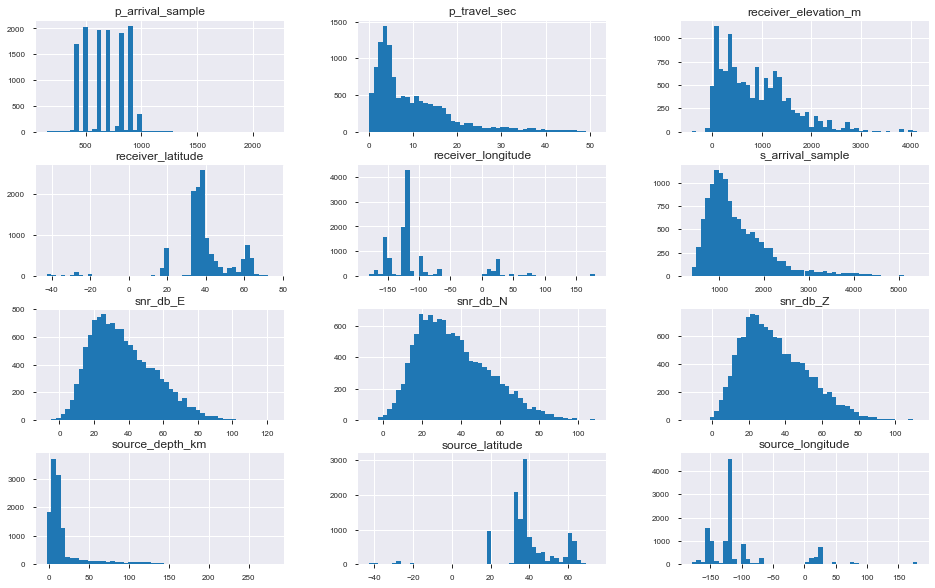

In [10]:
df_num.drop(['target'],axis=1).hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8);

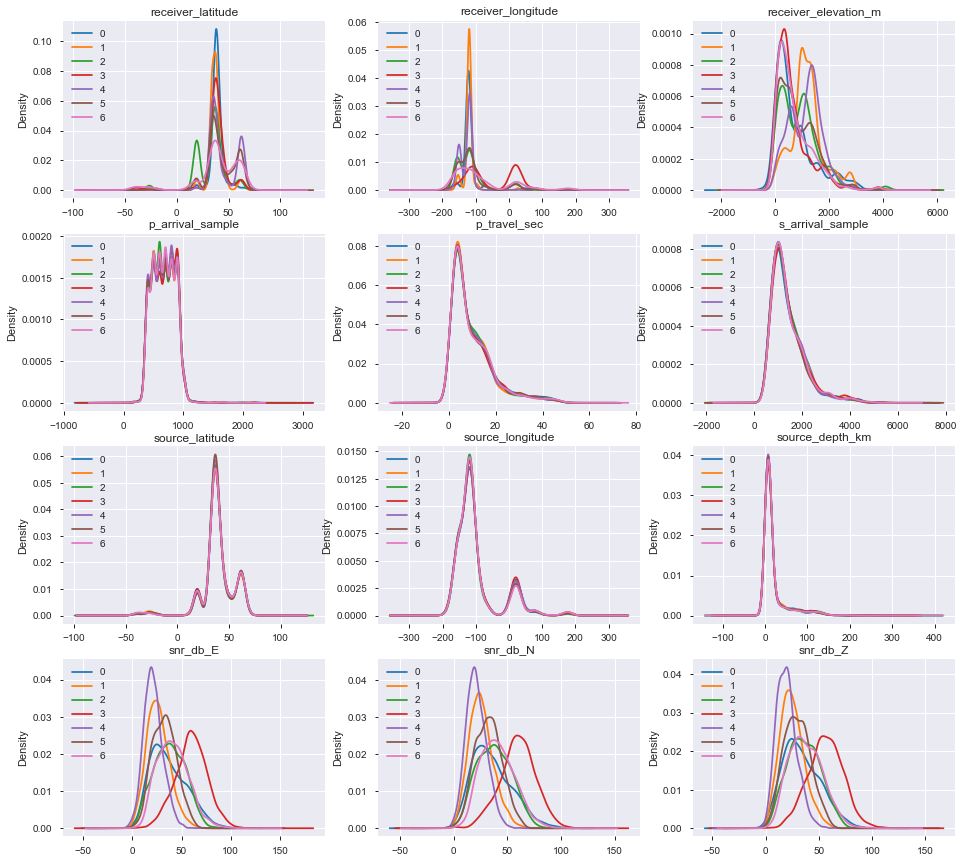

In [11]:
fig, ax = plt.subplots(ncols=3,nrows=4, figsize=(16,15))
ii = 0
for enum_col, col in enumerate(df_num.drop(['target'],axis=1).columns):
    if (enum_col!=0)&(enum_col%3==0):
        ii+=1
    df_num.groupby("target")[col].plot(kind='kde', ax=ax[ii, enum_col%3])
    ax[ii, enum_col%3].set_title(col)
    ax[ii, enum_col%3].legend(loc='upper left')

### Datetime

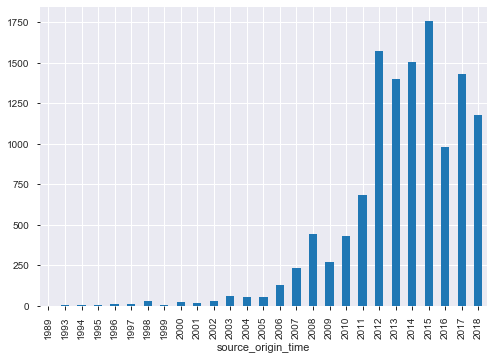

In [33]:
df_train['target'].groupby(df_train["source_origin_time"].dt.year).count().plot(kind="bar");

## Profile Report

In [16]:
profile = ProfileReport( df_train.drop(['E','N','Z'], axis=1))

In [17]:
profile.to_notebook_iframe()